## Skipgrams in Keras

- In this lecture, we will implement Skipgrams in `Keras`.

#### Loading in and preprocessing data
- Load the Alice in Wonderland data in Corpus using Keras utility
- `Keras` has some nice text preprocessing features too!
- Split the text into sentences.
- Use `Keras`' `Tokenizer` to tokenize sentences into words.

In [1]:
# Imports
# Basics
from __future__ import print_function, division
import pandas as pd 
import numpy as np
import random
from IPython.display import SVG
%matplotlib inline

# nltk
from nltk import sent_tokenize

# keras
np.random.seed(13)
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Activation
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot 
from keras.preprocessing.sequence import skipgrams

Using TensorFlow backend.


In [2]:
# We'll use Alice in Wonderland

path = get_file('carrol-alice.txt', origin="http://www.gutenberg.org/files/11/11-0.txt")
corpus = open(path).read()

In [3]:
corpus

'\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll\n\nThis eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.org\n\n\nTitle: Alice’s Adventures in Wonderland\n\nAuthor: Lewis Carroll\n\nPosting Date: June 25, 2008 [EBook #11]\nRelease Date: March, 1994\nLast Updated: October 6, 2016\n\nLanguage: English\n\nCharacter set encoding: UTF-8\n\n*** START OF THIS PROJECT GUTENBERG EBOOK ALICE’S ADVENTURES IN WONDERLAND ***\n\n\n\n\n\n\n\n\n\n\nALICE’S ADVENTURES IN WONDERLAND\n\nLewis Carroll\n\nTHE MILLENNIUM FULCRUM EDITION 3.0\n\n\n\n\nCHAPTER I. Down the Rabbit-Hole\n\nAlice was beginning to get very tired of sitting by her sister on the\nbank, and of having nothing to do: once or twice she had peeped into the\nbook her sister was reading, but it had no pictures or convers

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/wasit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Split document into sentences first
corpus = corpus[corpus.index('\n\n')+2:]  # remove header.
sentences = sent_tokenize(corpus)

# Tokenize using Keras
base_filter='!"#$%&()*+,-./:;`<=>?@[\\]^_{|}~\t\n' + "'"
tokenizer = Tokenizer(filters=base_filter)
tokenizer.fit_on_texts(sentences)

# Convert tokenized sentences to sequence format
sequences = tokenizer.texts_to_sequences(sentences)
nb_samples = sum(len(s) for s in corpus)

print(len(sequences), tokenizer.document_count)

1093 1093


In [6]:
sequences

[[22,
  444,
  31,
  24,
  1,
  150,
  6,
  707,
  1009,
  19,
  47,
  822,
  3,
  18,
  483,
  47,
  1308,
  1309],
 [11,
  174,
  345,
  8,
  315,
  8,
  169,
  27,
  1310,
  150,
  8,
  204,
  1,
  205,
  6,
  1,
  56,
  48,
  258,
  1010,
  18,
  22,
  444,
  27,
  823,
  19,
  627,
  48,
  316,
  1837,
  259,
  374,
  10,
  552,
  1838,
  1011,
  1012,
  1839,
  824,
  1840,
  1841,
  1842,
  444,
  825,
  1843,
  824,
  136,
  1844,
  139,
  1311,
  1845,
  1013,
  1846,
  1847,
  553,
  1312,
  197,
  1848,
  1849,
  708,
  1014,
  6,
  22,
  56,
  48,
  444,
  259,
  374,
  10,
  552,
  259,
  374,
  10,
  552,
  1011,
  1012,
  1,
  1850,
  1851,
  1313,
  375,
  1015,
  346,
  15],
 [37,
  1,
  109,
  709,
  12,
  13,
  277,
  4,
  116,
  29,
  554,
  6,
  407,
  59,
  17,
  484,
  20,
  1,
  1016,
  3,
  6,
  408,
  153,
  4,
  44,
  148,
  27,
  710,
  7,
  23,
  1017,
  68,
  1,
  376,
  17,
  484,
  13,
  826,
  30,
  8,
  23,
  47,
  827,
  27,
  1314,
  10,
  8,
  79,
 

In [7]:
# To understand what is happening;

print(sentences[324])  # this is a sentence
print(sequences[324])  # this is the same sentence where words are encoded as numbers.
print(list(tokenizer.word_index[word.lower().replace('.', '')] 
           for word in sentences[324].split()))

The Caterpillar was the first to speak.
[1, 182, 13, 1, 98, 4, 330]
[1, 182, 13, 1, 98, 4, 330]


#### Skipgrams: Generating Input and Output Labels
- Now that we have sentences, and word tokenization, we are in good position to create our training set for skipgrams.
- Now we need to generate our `X_train` and `y_train`

In [8]:
# Let's first see how Keras' skipgrams function works.

couples, labels = skipgrams(sequences[324], len(tokenizer.word_index) + 1,
    window_size=2, negative_samples=0, shuffle=True,
    categorical=False, sampling_table=None)

index_2_word = {val: key for key, val in tokenizer.word_index.items()}

for w1, w2 in couples:
    if w1 == 13:
        print(index_2_word[w1], index_2_word[w2])

was the
was first
was caterpillar
was the


In [9]:
# Function to generate the inputs and outputs for all windows

# Vocab size
vocab_size = len(tokenizer.word_index) + 1
# Dimension to reduce to
dim = 100
window_size = 2


def generate_data(sequences, window_size, vocab_size):
    for seq in sequences:
        X, y = [], []
        couples, _ = skipgrams(
            seq, vocab_size,
            window_size=window_size, negative_samples=0, shuffle=True,
            categorical=False, sampling_table=None)
        if not couples:
            continue
        for in_word, out_word in couples:
            X.append(in_word)
            y.append(np_utils.to_categorical(out_word, vocab_size))
        X, y = np.array(X), np.array(y)
        X = X.reshape(len(X), 1)
        y = y.reshape(len(X), vocab_size)
        yield X, y
        
data_generator = generate_data(sequences, window_size, vocab_size)

### Skipgrams: Creating the Model
- Lastly, we create the (shallow) network!

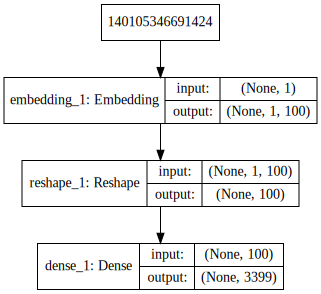

In [10]:
# Create the Keras model and view it 
skipgram = Sequential()
skipgram.add(Embedding(input_dim=vocab_size, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
skipgram.add(Reshape((dim,)))
skipgram.add(Dense(input_dim=dim, units=vocab_size, activation='softmax'))
SVG(model_to_dot(skipgram, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
skipgram.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 100)            339900    
_________________________________________________________________
reshape_1 (Reshape)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3399)              343299    
Total params: 683,199
Trainable params: 683,199
Non-trainable params: 0
_________________________________________________________________


### Skipgrams: Compiling and Training
- Time to compile and train
- We use crossentropy, common loss for classification

In [12]:
# Compile the Keras Model
from keras.optimizers import SGD
sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9)

skipgram.compile(loss='categorical_crossentropy', optimizer="adadelta")

# Fit the Skipgrams
for iteration in range(10):
    loss = 0
    for x, y in generate_data(sequences, window_size, vocab_size):
        loss += skipgram.train_on_batch(x, y)
    print('iteration {}, loss is {}'.format(iteration, loss))

iteration 0, loss is 8478.368712425232
iteration 1, loss is 7775.79335641861
iteration 2, loss is 7389.9481201171875
iteration 3, loss is 7170.008739471436
iteration 4, loss is 7037.91584610939
iteration 5, loss is 6950.1228239536285
iteration 6, loss is 6886.155944824219
iteration 7, loss is 6835.780887365341
iteration 8, loss is 6793.287715673447
iteration 9, loss is 6755.320825576782


### Skipgrams: Looking at the vectors

To get word_vectors now, we look at the weights of the first layer.

Let's also write functions giving us similarity of two words.

In [13]:
word_vectors = skipgram.get_weights()[0]


from scipy.spatial.distance import cosine


def get_dist(w1, w2):
    i1, i2 = tokenizer.word_index[w1], tokenizer.word_index[w2]
    v1, v2 = word_vectors[i1], word_vectors[i2]
    return cosine(v1, v2)

def get_similarity(w1, w2):
    return 1-get_dist(w1, w2)

def get_most_similar(w1, n=10):
    sims = {word: get_similarity(w1, word) 
            for word in tokenizer.word_index.keys()
            if word != w1}
    sims = pd.Series(sims)
    sims.sort_values(inplace=True, ascending=False)
    return sims.iloc[:n]


print(get_similarity('king', 'queen'))
print('')
print(get_most_similar('queen'))

0.9519008994102478

gryphon     0.969171
dormouse    0.966100
duchess     0.965378
march       0.957099
hatter      0.956556
king        0.951901
cat         0.945495
white       0.943479
mouse       0.939789
rabbit      0.938334
dtype: float64


## Your turn -- Modify the code above to create a CBOW Model